# Chapter 3: Classification

## Will be working on classification using MNIST dataset of handwritten digits

### Get and understand data from sklearn openml

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)

In [25]:
import numpy as np

X, y = mnist['data'], mnist['target']
print(X.shape, y.shape)
y = y.astype(np.uint8)

(70000, 784) (70000,)


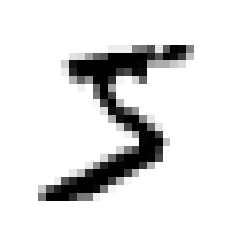

In [22]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0]
some_digit_image = some_digit.to_numpy().reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [32]:
#split train and test set (dataset already shuffled)
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### A simple binary classifier

In [34]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)

sgd_clf.predict(X[:1])

array([ True])

In [39]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

### Is it better than a dumb classifier?

In [43]:
from sklearn.base import BaseEstimator

class NeverClassify5(BaseEstimator):
    def fit(self, x, y=None):
        return self
    def predict(self, x):
        return np.zeros((len(x), 1), dtype=bool)
    
dumb_classifier = NeverClassify5()
cross_val_score(dumb_classifier, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix and other performance measures

In [45]:
from sklearn.model_selection import cross_val_predict

y_train_preds = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)
y_dumb_preds = cross_val_predict(dumb_classifier, x_train, y_train, cv=3)

In [48]:
from sklearn.metrics import confusion_matrix

#comparing confusion matrices
print(confusion_matrix(y_train_5, y_train_preds))
confusion_matrix(y_train_5, y_dumb_preds) # A lot of false negatives :D, no true positives /:(

[[53892   687]
 [ 1891  3530]]


array([[54579,     0],
       [ 5421,     0]])

In [51]:
# Precision = TP/(TP+FP) measures how accurate true predictions are on all classes
# Recall = TP/(FN+TP) measures how accurate predictions are on target class

from sklearn.metrics import precision_score, recall_score

print('SGD precision:', precision_score(y_train_5, y_train_preds))
print('SGD recall:', recall_score(y_train_5, y_train_preds))
print('Dumb precision:', precision_score(y_train_5, y_dumb_preds, zero_division=False)) # Very Bad Precision
print('Dumb recall:', recall_score(y_train_5, y_dumb_preds)) # Very bad recall 

SGD precision: 0.8370879772350012
SGD recall: 0.6511713705958311
Dumb precision: 0.0
Dumb recall: 0.0


In [52]:
# F1 score = 2/(1/precision + 1/recall) Harmonic mean of both the above
from sklearn.metrics import f1_score


print('SGD F1:', f1_score(y_train_5, y_train_preds))
print('Dumb F1:', f1_score(y_train_5, y_dumb_preds))

SGD F1: 0.7325171197343846
Dumb F1: 0.0


In [61]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

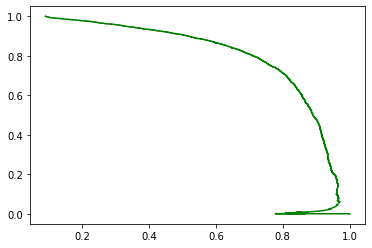

In [69]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'r-', label='recall')

    
# plot_precision_recall(precisions, recalls, thresholds)
plt.plot(precisions[:-1], recalls[:-1], 'g-', label='pvsr')

In [72]:
threshold_80_precision = thresholds[np.argmax(precisions >= 0.80)]
y_train_pred_90 = (y_scores > threshold_80_precision)

print(precision_score(y_train_5, y_train_pred_90))
recall_score(y_train_5, y_train_pred_90)

0.7999585835576724


0.7125991514480723

### ROC Curves

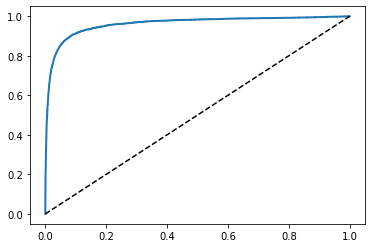

In [75]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, threshold):
    plt.plot(fpr, tpr, linewidth=2, label='fpr_vs_tpr')
    plt.plot([0, 1], [0, 1], 'k--')
    
plot_roc_curve(fpr, tpr, threshold)

In [76]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [79]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(x_train, y_train_5)

forest_probas = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method='predict_proba')


NameError: name 'fores_probas' is not defined

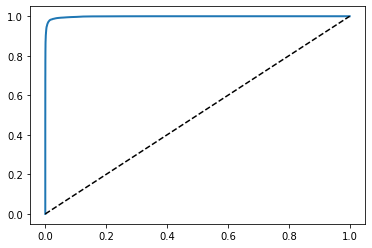

In [80]:
y_scores_forest = forest_probas[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plot_roc_curve(fpr_forest, tpr_forest, thresholds_forest)

In [81]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

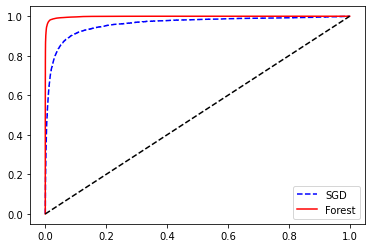

In [85]:
# compare SGD vs Random Forest PvR

plt.plot(fpr, tpr, 'b--', label='SGD')
plt.plot(fpr_forest, tpr_forest, 'r-', label='Forest')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()

In [99]:
# precision, recall scores

y_preds_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3)

forest_precision = precision_score(y_train_5, y_preds_forest)
forest_recall = recall_score(y_train_5, y_preds_forest)

print('precision: ', forest_precision)
print('recall: ', forest_recall)

f1_score(y_train_5, y_preds_forest)

precision:  0.9905083315756169
recall:  0.8662608374838591


0.9242275142688446

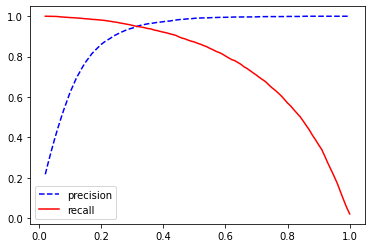

In [103]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores_forest)

plot_precision_recall(precisions, recalls, thresholds)
plt.legend()

### Noise remover - Multi Ouput Classifer

In [104]:
noise = np.random.randint(0, 100, (len(x_train), 784))
x_train_mod = x_train + noise
noise = np.random.randint(0, 100, (len(x_test), 784))
x_test_mod = x_test + noise

y_train_mod = x_train
y_test_mod = x_test

In [105]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train_mod, y_train_mod)

KeyError: 1

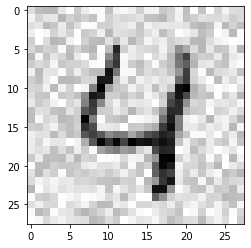

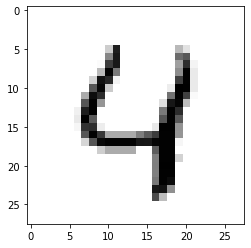

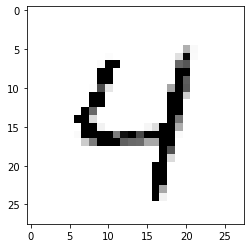

In [120]:
clean_digit = knn_clf.predict(x_test_mod[4:5])

def plot_digit(digit):
    plt.imshow(digit.reshape(28, 28), cmap='binary')
    
    
plot_digit(x_test_mod.iloc[4].to_numpy())
plt.show()
plot_digit(x_test.iloc[4].to_numpy())
plt.show()
plot_digit(clean_digit)

### End